In [1]:
import pandas as pd
import numpy as np
from pylab import plot, show
from scipy import stats
import matplotlib
from matplotlib import pyplot as plt
import os
import math
import pandas as pd
from matplotlib import pyplot as PLT
from matplotlib import mlab as ML
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind

% pylab inline
os.getcwd()

Populating the interactive namespace from numpy and matplotlib


'/Users/isaacpark/Dropbox/Herbarium_2017/Pheno_Assessed_3/FrostRisk/Data_ForSharing'

In [2]:
rawData = pd.read_csv('specimenData.csv')

####
# Accepted_name_species = species name
# DOY = Day of year on which specimen was collected
# Year = Year on which specimen was collected
# bFFP_Annual = Date of the beginning of the frost-free period at the location and year from which specimen was collected
# bFFP_Normal = Normal Date of the beginning of the frost-free period at the location from which specimen was collected (based on 1901-1990 Normals)



print len(rawData)
rawData.head()

670908


,Accepted_name_species,DOY,Year,bFFP_Annual,bFFP_Normal
0,Garrya elliptica,93.0,1920.0,76.0,62.333333
1,Anemone tuberosa,105.0,1920.0,125.0,119.666667
2,Perityle emoryi,74.0,1920.0,40.0,42.333333
3,Monoptilon bellioides,110.0,1920.0,104.0,89.666667
4,Plantago ovata,63.0,1920.0,51.0,45.666667


In [3]:
#Create field for evaluating magnitude of annual deviations from bffp normals
rawData['bFFP_ClimDiff'] = rawData['bFFP_Annual'] - rawData['bFFP_Normal']

#Create field marking whether a specimen was collected prior to the onset of the frost-free period
rawData['bFFP_Diff'] = rawData['DOY'] - rawData['bFFP_Annual']

#Create field marking mean collection date for all specimens of each species
bffP_Group = rawData.groupby(by = ['Accepted_name_species']).mean()
bffP_Group = bffP_Group.reset_index()
bffP_Group['DOY_SpecMean'] = bffP_Group['DOY']
bffP_Group['bFFP_Diff_SpecMean'] = bffP_Group['bFFP_Diff']
bffP_Group = bffP_Group.loc[:, ['Accepted_name_species', 'bFFP_Diff_SpecMean', 'DOY_SpecMean']]
print len(rawData)


670908


In [4]:
#Merge mean collection dates back into main data
rawData = pd.merge(rawData, bffP_Group, on = ['Accepted_name_species'], how = 'left')
print len(rawData)
rawData.head()

670908


,Accepted_name_species,DOY,Year,bFFP_Annual,bFFP_Normal,bFFP_ClimDiff,bFFP_Diff,bFFP_Diff_SpecMean,DOY_SpecMean
0,Garrya elliptica,93.0,1920.0,76.0,62.333333,13.666667,17.0,34.384615,86.723077
1,Anemone tuberosa,105.0,1920.0,125.0,119.666667,5.333333,-20.0,3.375000,87.464844
2,Perityle emoryi,74.0,1920.0,40.0,42.333333,-2.333333,34.0,45.504630,86.013889
3,Monoptilon bellioides,110.0,1920.0,104.0,89.666667,14.333333,6.0,37.139535,84.048837
4,Plantago ovata,63.0,1920.0,51.0,45.666667,5.333333,12.0,37.656987,86.152450


In [5]:
#Determine whether each specimen was collected prior to the beginning of the frost-free period

def frostChecker_bffp(row):  #check if bFFP occurred after flowering onset
    if row["bFFP_Annual"] < row['DOY']:
        return 0
    else:
        return 1
    
rawData["Frost_Suffered"] = rawData.apply(frostChecker_bffp, axis=1)


In [6]:
def MW_sampleCounter(inFrame, startYear, endYear): #within a given moving window, calculate number of specimens (samples) of each species
    iterFrame = inFrame[inFrame['Year']>=startYear]
    iterFrame = iterFrame[iterFrame['Year']<=endYear]
    iterFrame['Dummy'] = 1
    SC_Group = iterFrame.groupby(by = ['Accepted_name_species']).sum()
    SC_Group['Samplecount_'+ str(startYear) + "_" + str(endYear)] = SC_Group['Dummy']
    SC_Group.reset_index(inplace = True)
    SC_Group = SC_Group.loc[:, ['Accepted_name_species', 'Samplecount_'+ str(startYear) + "_" + str(endYear)]]
    return SC_Group

def MW_FrostSuffered(inFrame, startYear, endYear): #within a given moving window, eliminate species for which under the minimum number of specimens were collected, and calculate frost risk for each species
    iterFrame = inFrame[inFrame['Year']>=startYear]
    iterFrame = iterFrame[iterFrame['Year']<=endYear]
    iterFrame = iterFrame[iterFrame['Samplecount_'+ str(startYear) + "_" + str(endYear)] >= MW_Thresh]
    FS_Group = iterFrame.groupby(by = ['Accepted_name_species']).mean()
    
    FS_Group['FS_'+ str(startYear) + "_" + str(endYear)] = FS_Group['Frost_Suffered']
    FS_Group['bFFP_Dev' + str(startYear) + "_" + str(endYear)] = FS_Group['bFFP_ClimDiff']
    FS_Group['bFFP_Norm' + str(startYear) + "_" + str(endYear)] = FS_Group['bFFP_Normal']
    FS_Group.reset_index(inplace = True)
    FS_Group = FS_Group.loc[:, ['Accepted_name_species', 'FS_'+ str(startYear) + "_" + str(endYear), 'bFFP_Dev' + str(startYear) + "_" + str(endYear), 'bFFP_Norm' + str(startYear) + "_" + str(endYear)]]
    
    return FS_Group

In [7]:
#get mean values of frst risk and dates of beginning of the frost-free period for each species
speciesGroups = rawData.groupby(by = ['Accepted_name_species']).mean()
speciesGroups = speciesGroups.reset_index()
speciesGroups['FS_Overall'] = speciesGroups['Frost_Suffered']
del speciesGroups['Frost_Suffered']
speciesGroups = speciesGroups.loc[:, ['Accepted_name_species', 'FS_Overall', 'bFFP_Normal', 'bFFP_ClimDiff']]

speciesGroups_CountOnly = speciesGroups.loc[:, ['Accepted_name_species']] # get frame of species names only for merging with samplecounts
            #So that nan cells can be filled with zeroes - later merged with frost suffered by species, for which nan data cannot be replace by zeroes
speciesGroups.head()

,Accepted_name_species,FS_Overall,bFFP_Normal,bFFP_ClimDiff
0,Abronia elliptica,0.123894,120.840708,-4.141593
1,Abronia latifolia,0.015873,70.428571,-6.634921
2,Abronia maritima,0.037037,11.796296,1.555556
3,Abronia mellifera,0.016393,122.912568,-5.010929
4,Abronia pogonantha,0.061538,91.158974,-5.712821


In [8]:
#Calculate samplecount and frostrisk for each species within each moving window
#year = [ 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015]
years = np.arange(1920, 1996, 1)

MW_Length = 20 #defines length of each moving window in years
MW_Thresh = 40 #defines minimum number of specimens of a species within each window that is required for inclusion
rawData2 = rawData
#yearCatList = []

#for x in xrange(1+((2015 - 1920)/5)- (MW_Length/5)):
for x in xrange(len(years)):
    startYear = years[x] #start year of window
    endYear = years[x]+ 20 #end year of window
    
    #yearCatList.append((str(startYear) + '_' + str(endYear)))
    print 'startYear', startYear
    print 'endYear', endYear
    
    #calculate number of samples per species within window
    MW_Sample_Iter = MW_sampleCounter(rawData2, startYear, endYear) 
    
    #merge sample counts for each species within that window into rawData - enables exclusion of poorly sampled species during calculation of frost risk
    rawData2 = pd.merge(rawData2, MW_Sample_Iter, on = ['Accepted_name_species'], how = 'left')
    rawData2 = rawData2.fillna(0) #fills samplecounts for taxa not present in a given window with 0 rather than nan
    
    #merge specieswide samplecounts within a window into species data
    speciesGroups_CountOnly = pd.merge(speciesGroups_CountOnly, MW_Sample_Iter, on = ['Accepted_name_species'], how = 'left')
    
    #calculate frost risk for all species within a window, excluding poorly sampled species
    MW_FS_Iter = MW_FrostSuffered(rawData2, startYear, endYear)
    print "# Species: ", len(MW_FS_Iter)
    print ''
    
    #merge specieswide frost risk within a window into species data
    speciesGroups = pd.merge(speciesGroups, MW_FS_Iter, on = ['Accepted_name_species'], how = 'left')

#  merge specieswide samplecount data into specieswide means & frostrisk data  
speciesGroups_Complete = pd.merge(speciesGroups, speciesGroups_CountOnly, on = ['Accepted_name_species'], how = 'left')    
    

startYear 1920
endYear 1940
# Species:  918

startYear 1921
endYear 1941
# Species:  963

startYear 1922
endYear 1942
# Species:  967

startYear 1923
endYear 1943
# Species:  969

startYear 1924
endYear 1944
# Species:  978

startYear 1925
endYear 1945
# Species:  991

startYear 1926
endYear 1946
# Species:  1020

startYear 1927
endYear 1947
# Species:  1005

startYear 1928
endYear 1948
# Species:  1026

startYear 1929
endYear 1949
# Species:  1032

startYear 1930
endYear 1950
# Species:  1043

startYear 1931
endYear 1951
# Species:  1028

startYear 1932
endYear 1952
# Species:  1030

startYear 1933
endYear 1953
# Species:  994

startYear 1934
endYear 1954
# Species:  953

startYear 1935
endYear 1955
# Species:  892

startYear 1936
endYear 1956
# Species:  778

startYear 1937
endYear 1957
# Species:  732

startYear 1938
endYear 1958
# Species:  645

startYear 1939
endYear 1959
# Species:  593

startYear 1940
endYear 1960
# Species:  581

startYear 1941
endYear 1961
# Species:  530

sta

In [9]:
#drop rows with missing data (i.e. species which do not meet minimum specimen counts within every moving window)

print len(speciesGroups_Complete)
speciesGroups_Complete = speciesGroups_Complete.dropna()
print len(speciesGroups_Complete)

4058
268


In [10]:
speciesGroups_Complete.to_csv('MovingWindow_Frostrisk.csv', index=False)
speciesGroups_Complete.head()

#at this point the data can be filtered by bFFP normal in order to examine ofnly species inhabiting locations with either earlier or later frosts than the median across all scpecies, if desired

,Accepted_name_species,FS_Overall,bFFP_Normal,bFFP_ClimDiff,FS_1920_1940,bFFP_Dev1920_1940,bFFP_Norm1920_1940,FS_1921_1941,bFFP_Dev1921_1941,bFFP_Norm1921_1941,...,Samplecount_1986_2006,Samplecount_1987_2007,Samplecount_1988_2008,Samplecount_1989_2009,Samplecount_1990_2010,Samplecount_1991_2011,Samplecount_1992_2012,Samplecount_1993_2013,Samplecount_1994_2014,Samplecount_1995_2015
26,Achillea millefolium,0.034636,149.740557,-3.367475,0.058394,-5.014599,146.197080,0.056338,-5.269953,145.093897,...,645.0,721.0,853.0,977.0,1088.0,1207.0,1242.0,1241.0,1252.0,1256.0
33,Aconitum columbianum,0.026975,167.016699,-3.086063,0.011236,-1.711610,160.902622,0.010638,-2.826241,162.166667,...,150.0,168.0,174.0,172.0,179.0,189.0,195.0,194.0,201.0,207.0
57,Agoseris glauca,0.101138,165.475348,-3.597977,0.077778,-2.540741,161.885185,0.075269,-3.000000,160.795699,...,220.0,245.0,304.0,341.0,361.0,380.0,379.0,375.0,374.0,369.0
111,Alopecurus aequalis,0.069307,153.426843,-3.839384,0.060000,-3.666667,146.686667,0.056604,-3.981132,147.037736,...,93.0,92.0,87.0,89.0,87.0,85.0,94.0,92.0,91.0,90.0
140,Amelanchier utahensis,0.392683,133.443089,-3.301626,0.353535,0.303030,123.454545,0.362745,-0.712418,122.761438,...,99.0,104.0,109.0,115.0,120.0,128.0,118.0,126.0,126.0,127.0


In [11]:
# Create mean values (across species) for each 20-year window
years = np.arange(1920, 1996, 1)

yearCatList = [] #blank list for populating with ID of each window
meanFSList = [] #blank list for populating with mean frost risk for each window
meanYearList = [] #blank list for populating with central year of each window
meanSCList = [] #blank list for populating with mean sample count for each window
bFFDDiffsList = [] #blank list for populating with mean annual deviation from local dates on which the frost-free period began for each window
bFFPNormList = [] #blank list for populating with normal dates on which the frost-free period for each window

#iterate across windows, populating lists with mean values from within each window
for x in xrange(len(years)):
    startYear = years[x]
    endYear = years[x]+ 20
    meanYear = (startYear + endYear)/2
    
    meanYearList.append(meanYear)
    
    yearCatList.append((str(startYear) + '_' + str(endYear)))
    
    meanFSList.append(speciesGroups_Complete['FS_' + str(startYear) + '_' + str(endYear)].mean())
    meanSCList.append(speciesGroups_Complete['Samplecount_' + str(startYear) + '_' + str(endYear)].mean())
    bFFDDiffsList.append(speciesGroups_Complete['bFFP_Dev' + str(startYear) + '_' + str(endYear)].mean())
    bFFPNormList.append(speciesGroups_Complete['bFFP_Norm' + str(startYear) + '_' + str(endYear)].mean())
    
#Convert Lists of mean values within moving windows into single dataframe
MW_Data = pd.DataFrame(index=meanYearList)
MW_Data['Mean SampleCounts'] = meanSCList
MW_Data['Mean FrostRisk'] = meanFSList
MW_Data['Mean BFFP_DIFFS'] = bFFDDiffsList
MW_Data['Mean BFFP_Normals'] = bFFPNormList

MW_Data.to_csv('MovingWindowData_WindowMeans.csv')
print len(MW_Data)
MW_Data

76


,Mean SampleCounts,Mean FrostRisk,Mean BFFP_DIFFS,Mean BFFP_Normals
1930,99.444030,0.135230,-1.716921,132.523157
1931,102.966418,0.132589,-2.399777,132.602726
1932,102.865672,0.132730,-2.361862,132.644329
1933,102.384328,0.132213,-2.537275,132.467273
1934,105.074627,0.130311,-2.598016,133.016023
1935,105.656716,0.129439,-2.635758,133.233036
1936,107.600746,0.130971,-2.428275,133.282770
1937,108.496269,0.127323,-2.627843,133.369815
1938,110.089552,0.125792,-2.787753,133.673928
1939,111.891791,0.125652,-2.748300,133.536411


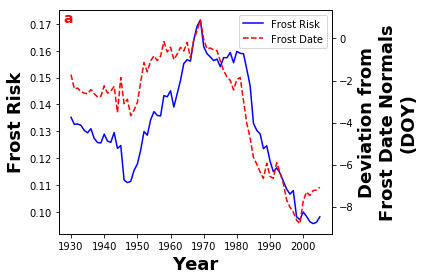

In [12]:
#Construct Figure 3a
fig = plt.figure()
fig, ax1 = plt.subplots()
plt.ylabel('Frost Risk', fontweight = 'bold', fontsize = 18)
plt.xlabel('Year', fontweight = 'bold', fontsize = 18 )
ax2 = ax1.twinx()

plt1 = ax1.plot(meanYearList, MW_Data['Mean FrostRisk'], color = 'blue', label = 'Frost Risk')
plt2 = ax2.plot(meanYearList, MW_Data['Mean BFFP_DIFFS'], color = 'red', label = 'BFFP_Devs', linestyle = '--')
legend((plt1[0], plt2[0]), ('Frost Risk', 'Frost Date'), loc=(0.66,0.83))    

plt.ylabel('Deviation from\nFrost Date Normals\n(DOY)', fontweight = 'bold', fontsize = 18 )
plt.xlabel('Year', fontweight = 'bold', fontsize = 18 )
plt.text(1930.5, 1.3, 'a', fontweight = 'bold', fontsize = 14, verticalalignment= 'top', horizontalalignment= 'right', color = 'red')

#second_axes.axis["right"].label.set_color(p2.get_color())

#plt.text(1930,-1.5, str(len(data)) + ' Species\n' + str(MW_Thresh) + ' Samples Minimum', fontweight = 'bold', fontsize = 12, verticalalignment= 'bottom', horizontalalignment= 'left')
plt.tight_layout()
plt.savefig('Fig_3a.jpg')


plt.show()

r_value: 0.805412847831
p_value: 1.76746588737e-18
gradient:  0.00619121138165


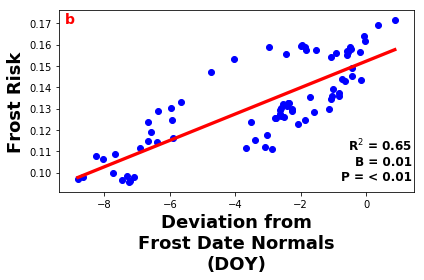

In [13]:
#Construct Figure 3b

#Convert series into arrays for regression & other processing
X = np.array(MW_Data['Mean BFFP_DIFFS']) 
Y = np.array(MW_Data['Mean FrostRisk'])
XConv = X

#Calculate parameters from linear regression
gradient, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
print 'r_value:', r_value
print 'p_value:', p_value
print 'gradient: ', gradient 


#creating spaced data to create plot line
x_new = np.linspace(X.min(), X.max(), 100)

#calculate y vals for regression line
y_new =  (gradient*x_new) +  intercept

plt.plot(x_new,y_new, "r", linewidth=3.3,)


r_string = str(round(r_value **2, 2))

gradient_string = str(round(gradient,2))

if p_value<0.01:
    p_string = "< 0.01"
else:
    p_string = str(round(p_value, 2))

plt1 = plt.scatter(MW_Data['Mean BFFP_DIFFS'], MW_Data['Mean FrostRisk'], color = 'blue', label = 'Frost Risk')


if round(r_value*r_value,2) <0.01:
    inset = "R$^2$ < " +  '0.01' + '\nB = ' + gradient_string + '\nP' + p_string
elif round(r_value*r_value,2) >=0.01:
    inset = "R$^2$ = " +  r_string + '\nB = ' + gradient_string + '\nP = ' + p_string
    

#Insetting Text into Figure
plt.text(1.4, 0.095, inset, fontweight = 'bold', fontsize = 12, verticalalignment= 'bottom', horizontalalignment= 'right')
plt.text(-8.9, 0.175, 'b', fontweight = 'bold', fontsize = 14, verticalalignment= 'top', horizontalalignment= 'right', color = 'red')



plt.ylabel('Frost Risk', fontweight = 'bold', fontsize = 18 )
plt.xlabel('Deviation from\nFrost Date Normals\n(DOY)', fontweight = 'bold', fontsize = 18 )

plt.tight_layout()
plt.savefig('Fig_3b.jpg')
plt.show()